In [55]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.special import softmax

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
# 208 seq len
out = np.load('model_out.npy')
labels = np.load('test_labels.npy')

In [5]:
def plot_labels(labels, **kwargs):
    
    labels = labels.reshape(250, 250)
    
    # find first -1, position to slice off
    # max to avoid gaps
    length = np.max(np.argmin(labels, axis=0))
    labels = labels[:length, :length]
    
    cmap = plt.cm.get_cmap('viridis_r', 10)
    plt.imshow(labels, cmap=cmap, **kwargs)
    cbar = plt.colorbar()
    
    tick_locs = (np.arange(10) + 0.5) * 9/10
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(np.arange(10))
    cbar.set_label('Distance Bin')

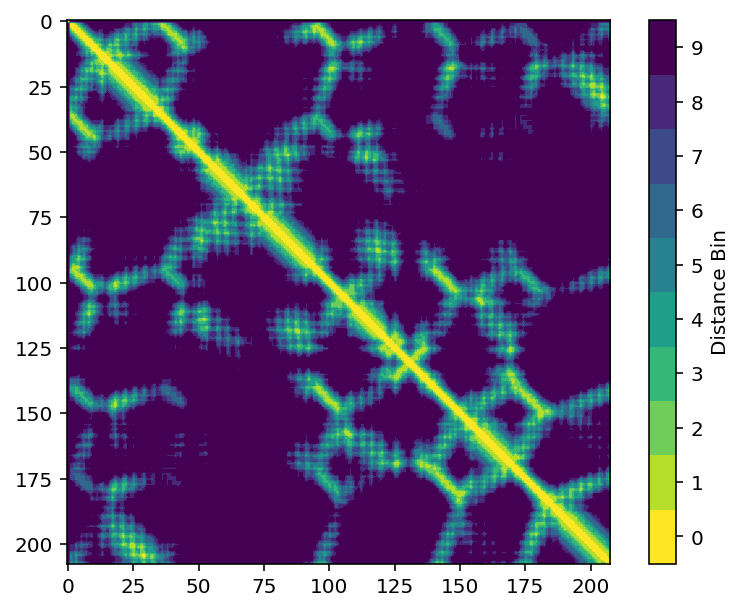

In [6]:
fig = plt.figure(figsize=(7, 5))

plot_labels(labels)

In [7]:
# plot contact categories

seq_len = 208
seq_range = np.arange(seq_len)
xx, yy = np.meshgrid(seq_range, seq_range)

short_mask = (np.abs(xx - yy) >= 6) & (np.abs(xx - yy) <= 11)
med_mask = (np.abs(xx - yy) >= 12) & (np.abs(xx - yy) <= 23)
long_mask = np.abs(xx - yy) >= 24

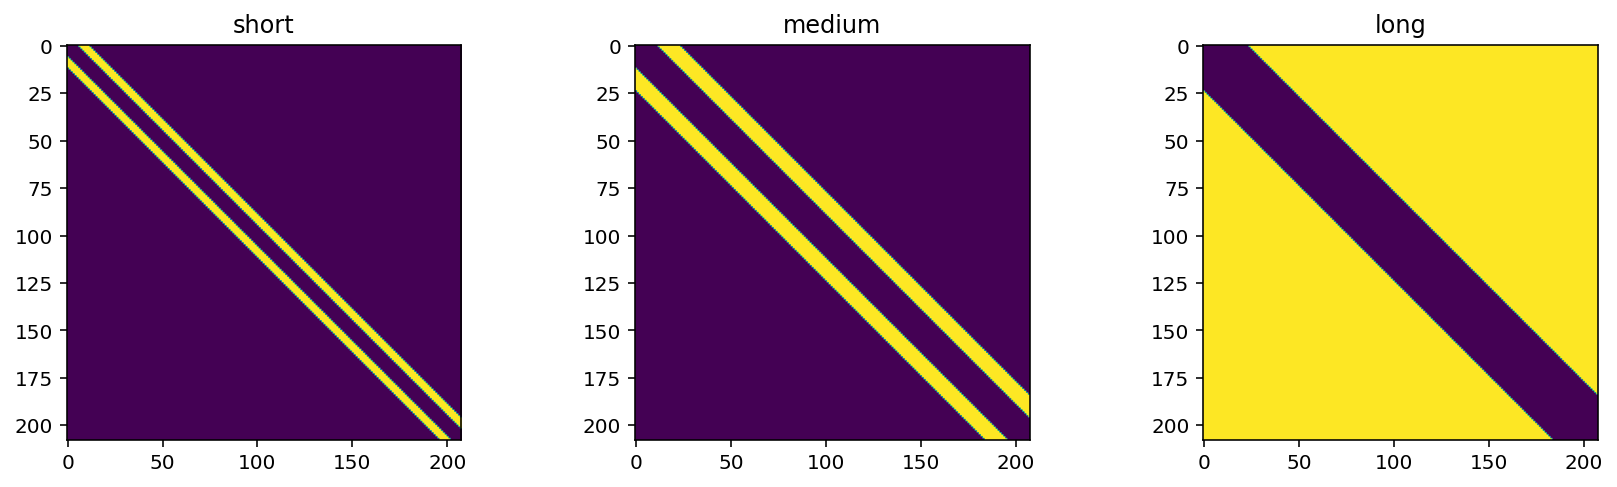

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

ax[0].imshow(short_mask)
ax[1].imshow(med_mask)
ax[2].imshow(long_mask)

ax[0].set_title('short')
ax[1].set_title('medium')
ax[2].set_title('long')

plt.tight_layout()

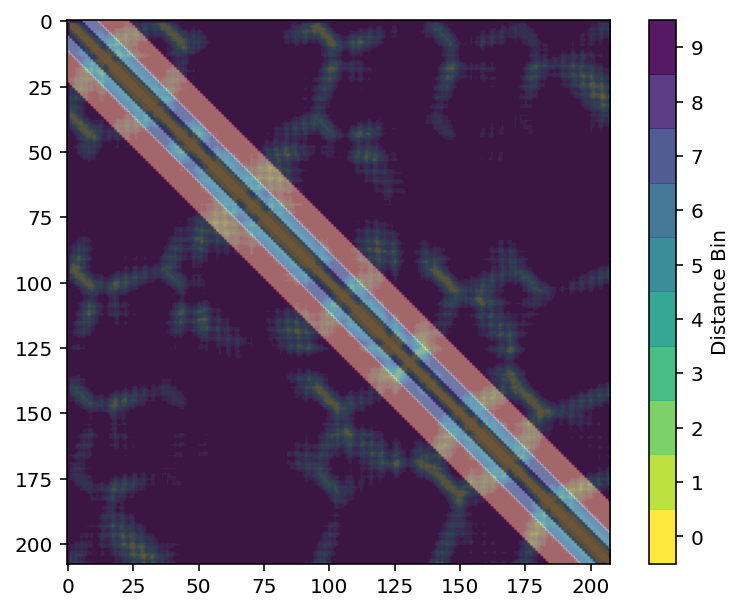

In [9]:
# overlay plot of contact cats and distrogram

fig = plt.figure(figsize=(7, 5))

plot_labels(labels, alpha=0.9)

# combine maps
med_up = np.where(med_mask, med_mask + 1, 0)
long_up = np.where(long_mask, long_mask + 2, 0)

mask = short_mask + med_up + long_up

plt.imshow(mask, alpha=0.7, cmap='twilight_shifted')

In [10]:
def contact_precision(model_out, labels, seq_len, contact, top, max_len=250):
    
    assert contact in ['short', 'med', 'long'], 'invalid contact'
    assert top in ['l', 'l/2', 'l/5'], 'invalid top'
    
    seq_range = np.arange(seq_len)
    xx, yy = np.meshgrid(seq_range, seq_range)
    
    # distance in sequence
    # 6 <= x <= 11
    if contact == 'short':
        mask = (np.abs(xx - yy) >= 6) & (np.abs(xx - yy) <= 11)
    
    # 12 <= x <= 23
    elif contact == 'med':
        mask = (np.abs(xx - yy) >= 12) & (np.abs(xx - yy) <= 23)
        
    # >= 24
    else:
        mask = np.abs(xx - yy) >= 24
        
    # set contact bin probs
    # 0-8 A
    contact_map = np.where((labels <= 3) & (labels >= 0) == True, 1, 0).reshape(1, max_len, max_len)
    
    # selection mask
    # ignore disordered
    not_disordered = np.where(labels != -1, 1, 0)
    to_pad = max_len - seq_len
    mask = (np.pad(mask, (0, to_pad)) * not_disordered).reshape(1, max_len, max_len)
    
    # softmax on model output, logits to preds
    softmaxed = softmax(model_out, axis=1)
    
    # add probabilities for bins 0-8A 
    probs = softmaxed[:, :3, :, :].sum(axis=1)
    
    # mask out
    probs = probs * mask
    #contact_map = contact_map * mask
    
    # select number of samples
    if top == 'l/2':
        res_range = seq_len // 2
    elif top == 'l/5':
        res_range = seq_len // 5
    else:
        res_range = seq_len
    
    # get most confident predictions
    # argsort and order decreasing
    probs = probs.ravel()
    probs_idx = np.argsort(probs)[::-1][:res_range]
    #probs_idx = np.argpartition(probs, -res_range, axis=0)[::-1][:res_range]
    
    # get pred and true at probs_idx
    # to class label, to contact
    #sel_preds = np.argmax(softmaxed, axis=1).ravel()[probs_idx]
    #sel_preds = np.where(sel_preds < 3, 1, 0)
    
    sel_contacts = contact_map.ravel()[probs_idx]
    #print(sel_contacts.sum(), res_range)
    
    return sel_contacts.sum() / res_range * 100

In [11]:
contact_precision(out, labels, seq_len, 'short', 'l')

8.173076923076923

In [12]:
contact_precision(out, labels, seq_len, 'med', 'l')

5.769230769230769

In [13]:
seq_len = 208

In [14]:
contacts = ['short', 'med', 'long']
tops = ['l', 'l/2', 'l/5']

# not working?
for contact in contacts:
    for top in tops:
        res = contact_precision(out, labels, seq_len, contact, top)
        print(f'contact: {contact}\t top: {top} \t precision: {res:.2f}%')

contact: short	 top: l 	 precision: 8.17%
contact: short	 top: l/2 	 precision: 6.73%
contact: short	 top: l/5 	 precision: 4.88%
contact: med	 top: l 	 precision: 5.77%
contact: med	 top: l/2 	 precision: 8.65%
contact: med	 top: l/5 	 precision: 7.32%
contact: long	 top: l 	 precision: 7.21%
contact: long	 top: l/2 	 precision: 3.85%
contact: long	 top: l/5 	 precision: 4.88%


In [15]:
x = np.random.randint(10, size=(10,))

In [16]:
x

array([3, 5, 4, 7, 2, 6, 5, 9, 8, 5])

In [17]:
np.argsort(x)[::-1]

array([7, 8, 3, 5, 9, 6, 1, 2, 0, 4], dtype=int64)

In [18]:
np.argpartition(x, -5)[:5-1:-1]

array([7, 8, 3, 5, 1], dtype=int64)

In [19]:
out = torch.from_numpy(out)
labels = torch.from_numpy(labels)

In [21]:
out.shape, labels.shape

(torch.Size([1, 10, 250, 250]), torch.Size([1, 1, 250, 250]))

In [67]:
def get_mask(seq_len, labels, contact, max_len):

    '''select region to calculate contact precision over'''

    # make grid
    seq_range = torch.arange(seq_len)
    xx, yy = torch.meshgrid(seq_range, seq_range)
    
    # distance in sequence
    # 6 <= x <= 11
    if contact == 'short':
        mask = (torch.abs(xx - yy) >= 6) & (torch.abs(xx - yy) <= 11)
    
    # 12 <= x <= 23
    elif contact == 'med':
        mask = (torch.abs(xx - yy) >= 12) & (torch.abs(xx - yy) <= 23)
        
    # >= 24
    else:
        mask = torch.abs(xx - yy) >= 24
        
    # set contact bin probs
    # 0-8 A
    condition = (labels <= 3) & (labels >= 0)
    contact_map = torch.where(condition, torch.tensor(1.), torch.tensor(0.)).view(1, max_len, max_len)
    
    # selection mask
    # ignore disordered
    not_disordered = torch.where(labels != -1, torch.tensor(1.), torch.tensor(0.))
    to_pad = max_len - seq_len
    mask = (F.pad(mask, (0, to_pad, 0, to_pad)) * not_disordered).view(1, max_len, max_len)

    return mask, contact_map

In [68]:
mask, contact = get_mask(208, labels, 'short', 250)

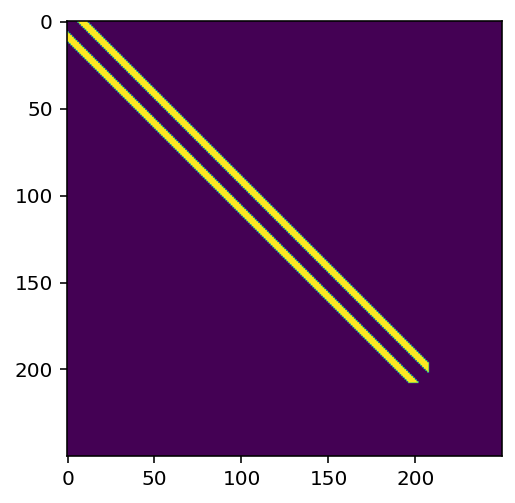

In [69]:
plt.imshow(mask.numpy().reshape(250, 250))

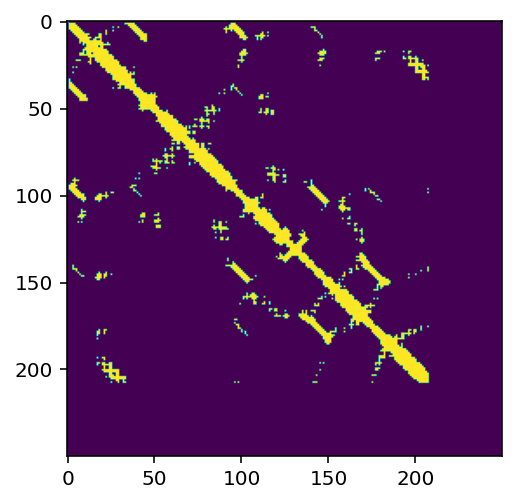

In [70]:
plt.imshow(contact.numpy().reshape(250, 250))

In [114]:
def contact_precision(model_out, labels, seq_len, contact, top, max_len=250):

    '''calculate contact precision over selected sequence distance and length range'''

    assert contact in ['short', 'med', 'long'], 'invalid contact'
    assert top in ['l', 'l/2', 'l/5'], 'invalid top'

    mask, contact_map = get_mask(seq_len, labels, contact, max_len)
    mask = mask.view(1, max_len, max_len)
    contact_map = contact_map.view(1, max_len, max_len)

    # softmax on model output, logits to preds
    softmaxed = F.softmax(model_out, dim=1)

    # add probabilities for bins 0-8A
    probs = softmaxed[:, :3, :, :].sum(dim=1)

    # mask out
    probs = probs * mask

    # select number of samples
    if top == 'l/2':
        res_range = seq_len // 2
    elif top == 'l/5':
        res_range = seq_len // 5
    else:
        res_range = seq_len

    # get index of most confident predictions
    # argsort and order decreasing
    probs = probs.flatten()
    probs_idx = torch.argsort(probs, descending=True)[:res_range]

    # from percent to contact prediction
    pred = torch.tensor([1 if probs[idx] >= 0.5 else 0 for idx in probs_idx])

    # get true labels at selected indices
    sel_contacts = contact_map.flatten()[probs_idx]
    
    correct = (pred == sel_contacts).sum().float()

    return (correct / res_range * 100).item()

In [115]:
contact_precision(out, labels, 250, 'short', 'l')

10.0

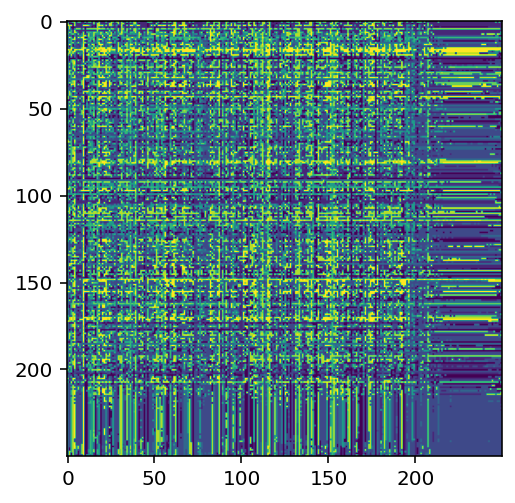

In [123]:
plt.imshow(torch.argmax(F.softmax(out, dim=1), dim=1).numpy().reshape(250, 250))